In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

/home/eurastof/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Making coordinate data (common atoms)

traj_dirs = ["/wrk/eurastof/binding_spots_project/validation/a2ar_site_*",
             #"/wrk/eurastof/binding_spots_project/validation/d2_site_*",
             "/wrk/eurastof/binding_spots_project/validation/d3_site_*",
             "/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/*"]
#gro_ext = ["/run*/aligned.gro", "/run*/aligned.gro", "/run*/aligned.gro", "/*gro"]
gro_ext = ["/run*/aligned.gro", "/run*/aligned.gro", "/*gro"]
#xtc_ext = ["/run*/aligned.xtc", "/run*/aligned.xtc", "/run*/aligned.xtc", "/*xtc"]
xtc_ext = ["/run*/aligned.xtc", "/run*/aligned.xtc", "/*xtc"]

ndx_files = ["/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/a2ar_common.ndx",
             #"/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/d2_common.ndx",
             "/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/d3_common.ndx",
             "/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/b2ar_common.ndx"
            ]
#skips = [50, 50, 50, 10]
skips = [50, 50, 10]

ref = mda.Universe("/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/popc/step6.6_equilibration.gro")
with open("/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/b2ar_common.ndx") as f:
        lines = "".join(f.readlines())
ref_resids = " ".join(re.findall(r"\d+", lines)[1:])

ids = []

for i, p in  enumerate(traj_dirs):
    print(p)
    skip = skips[i]
    for d in glob.glob(p):
        gro = glob.glob(d + gro_ext[i])[0]
        xtcs = glob.glob(d + xtc_ext[i])
        cosmos = mda.Universe(gro, xtcs)
        mean_length = np.mean([mda.Universe(gro, xtc).trajectory[-1].time/1000000 for xtc in xtcs])
        print(f"Avg. traj. length {mean_length}")     
        for ts in cosmos.trajectory[0:-1:skip]:
            ids.append(i)

np.save("./a2ar_b2ar_d3_ids.npy", np.array(ids))            
coordinates = []

for i, p in  enumerate(traj_dirs):
    
    with open(ndx_files[i]) as f:
        lines = "".join(f.readlines())

    resids = " ".join(re.findall(r"\d+", lines)[1:])
    skip = skips[i]
    
    for d in glob.glob(p):
        gro = glob.glob(d + gro_ext[i])[0]
        xtcs = glob.glob(d + xtc_ext[i])
        
        cosmos = mda.Universe(gro, xtcs)
        common_ca = cosmos.select_atoms(f"bynum {resids}")
        
        for ts in cosmos.trajectory[0:-1:skip]:
            align.alignto(cosmos, ref, select=(f"bynum {resids}", f"bynum {ref_resids}"), tol_mass=100)
            coords = common_ca.positions.flatten()
            coordinates.append(coords.reshape(1, coords.shape[0]))

X = np.concatenate(coordinates)
np.save("./a2ar_b2ar_d3_common_ca_coordinates.npy", X)




## Autoencoder pipeline

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


import torch
from torch import nn, optim

import random


In [4]:

class Autoencoder(BaseEstimator, TransformerMixin, nn.Module):

    def __init__(self, in_shape=10, enc_shape=2, middle_shape=5, n_hidden=1, loss_fn=nn.L1Loss(), lr=1e-3):
        
        super().__init__()
        self.loss_fn = loss_fn
        self.lr = lr 
        self.n_hidden = n_hidden # number of hidden layers
        self.in_shape = in_shape # input dimension
        self.enc_shape = enc_shape # dimension of encoding
        self.middle_shape = middle_shape # hidden layer dimensions
        
        encoder_layers = [nn.Linear(self.in_shape, self.middle_shape), nn.ReLU(), nn.Dropout(0.2)] # initialize encoder layer list
        decoder_layers = [nn.Linear(self.enc_shape, self.middle_shape), nn.ReLU(), nn.Dropout(0.2)] # initialize decoder layer list

        for i in range(n_hidden - 1): # Add layers to encoder and decoder according to n_hidden and middle shape
            encoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(0.2))
            decoder_layers.append(nn.Linear(self.middle_shape, self.middle_shape))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(0.2))
            
        encoder_layers.append(nn.Linear(self.middle_shape, self.enc_shape)) # Final encoder layer
        decoder_layers.append(nn.Linear(self.middle_shape, self.in_shape)) # Final decoder layer
        #decoder_layers.append(nn.Sigmoid()) # Sigmoid at end of deocder?

        self.encode = nn.Sequential(*encoder_layers) # Make encoder
        self.decode = nn.Sequential(*decoder_layers) # Make decoder
        

    def fit(self, X, y=None, n_epochs=20, batch_size=32, verbose=False):
        self.training = True # Enables e.g. dropouts to work
        X = torch.Tensor(X)
        indices = [i for i in range(X.shape[0])]
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr) # Adam only atm
        
        for epoch in range(n_epochs):
        
            random.shuffle(indices) # random shuffle to get random batches for each epoch
            batches = [i for i in range(0, len(indices), batch_size)]

            for i in range(len(batches) - 1):

                batch_X = X[indices[batches[i]:batches[i+1]]]
                self.optimizer.zero_grad() # reset optimizer
                
                encoded = self.encode(batch_X)
                decoded = self.decode(encoded)

                loss = self.loss_fn(decoded, batch_X)
                """l1_norm = sum(abs(p).sum()
                            for p in self.parameters())

                loss += 0.001 * l1_norm"""
                loss.backward() # Backpropagate
                self.optimizer.step() # Apply changes
            
            if verbose:
                print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
        
        return self

    def transform(self, X, y=None):
        encoded = self.encode(torch.Tensor(X))
        return encoded.cpu().detach().numpy()
    

    def inverse_transform(self, X, y=None):
        decoded = self.decode(torch.Tensor(X))
        return decoded.cpu().detach().numpy()
    
    def score(self, X, y=None):
        encoded = self.transform(X)
        decoded = self.inverse_transform(encoded)
        
        return -self.loss_fn(torch.Tensor(X), torch.Tensor(decoded)) # Take negative to make GridSearchCV work properly
        
    
    



In [5]:
# Grid of parameters for gridsearch

param_grid = {
    "Autoencoder__middle_shape": [512, 1024, 2048],
    "Autoencoder__enc_shape": [2, 3, 4],
    "Autoencoder__n_hidden": [1, 2, 3, 4],
}

In [6]:
# Function to search parameters and return best model

def pipeline(transformer, param_grid, X):
    
    pipe = Pipeline(
        steps=[
            ("Scaler", StandardScaler()),
            ("Autoencoder", transformer),
        ]   
    )
    
    gridsearch = GridSearchCV(pipe, param_grid=param_grid, verbose=3, cv=2)
    gridsearch.fit(X)
    
    return gridsearch.best_estimator_
    
    
    

In [7]:
#device = ('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"  # GridSearchCV having issues with GPUs
print(f"Using {device} device.")

Using cpu device.


## Autoencoder pipeline testing

In [15]:
with open('b2ar_CA_coords.pickle', 'rb') as handle:
    data_dict = pkl.load(handle)


X = np.concatenate([v for k, v in data_dict.items()]) # Input data (CA coordinates)
ids = np.concatenate([[i for i in range(v.shape[0])] for v in data_dict.values()]).reshape(-1,1) # Id for every lipid environment


In [17]:
best = pipeline(Autoencoder(in_shape=X.shape[1]), param_grid, X)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=1;, score=-0.718 total time=   2.4s
[CV 2/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=1;, score=-0.745 total time=   2.4s
[CV 1/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=2;, score=-0.720 total time=   2.4s
[CV 2/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=2;, score=-0.735 total time=   2.4s
[CV 1/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=3;, score=-0.736 total time=   2.5s
[CV 2/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=3;, score=-0.740 total time=   2.4s
[CV 1/2] END Autoencoder__enc_shape=2, Autoencoder__middle_shape=512, Autoencoder__n_hidden=4;, score=-0.720 total time=   2.4s
[CV 2/2] END Autoencoder__enc_shape=2, Auto

In [18]:
# Train test split

test = 0.25
index = [_ for _ in range(X.shape[0])]
random.shuffle(index)
test_index = index[:int(test*len(index))]
train_index = index[int(test*len(index)):]
test_X = torch.Tensor(X[test_index,:])
test_ids = ids[test_index]
train_X = torch.Tensor(X[train_index,:])
train_ids = ids[train_index]


In [32]:
# Test model

encoded = torch.Tensor(best.transform(test_X))
decoded = best.inverse_transform(encoded)
error = np.mean(np.abs(np.array(test_X) - decoded))
print(error) # Reconstruction error in Å


1.1737251


In [33]:
# TM36 distance calculation from coordinates

r1 = 99*3
r2 = 240*3
A = test_X[:,r1:r1+3]
B = test_X[:,r2:r2+3]
C = np.array(A - B)

tm36 = np.sqrt(np.sum(C**2, axis=1))


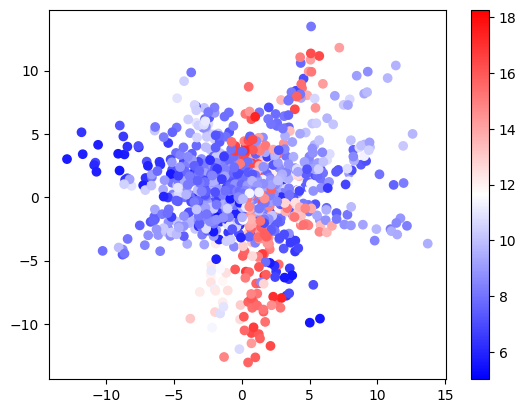

In [38]:
# Plot encoding, color by TM36 value
sc = plt.scatter(encoded[:,0], encoded[:,1], c=tm36, cmap="bwr")
plt.colorbar(sc)
plt.show()


## Input perturbation analysis

In [33]:
from sklearn.utils import shuffle

In [34]:

def IPA(X, model):
        
    
    index = np.arange(0, X.shape[1], 3)
    effects = []
    
    for i in index:
        shuffled = X.copy()
        shuffled = shuffle(shuffled)
        rands = np.random.uniform(low=-5, high=5, size=(shuffled.shape[0],1))
        rands = np.concatenate([rands, rands, rands], axis=1)
        shuffled[:, i:i+3] = rands
        encoded = model.transform(shuffled)
        decoded = model.inverse_transform(encoded)
        decoded = s.inverse_transform(decoded)
        L1 = np.mean(np.abs(X - decoded))
        effects += [L1, L1, L1]
    
    return effects
    
       
eff = IPA(X, best)



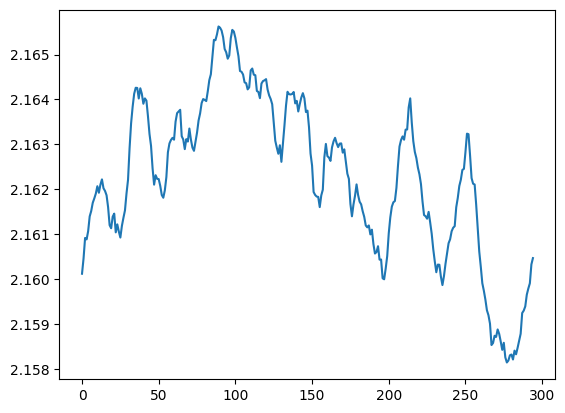

In [35]:
N = 50
E = np.convolve(eff, np.ones(N)/N, mode='valid')

plt.plot(E[0:-1:3])

## Movie creation

cosmos = mda.Universe("/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/popc/step6.6_equilibration.gro",
                      "/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/popc/centered_aligned10.xtc")
with open("/wrk/eurastof/binding_spots_project/HFSP---Lipid-binding-states/calculations/b2ar_common.ndx") as f:
        lines = "".join(f.readlines())
index = " ".join(re.findall(r"\d+", lines)[1:])
common_ca = cosmos.select_atoms(f"bynum {index}")
common_ca.write("common_ca.gro")

enc_vals = enc[:,1]
n_bins = 10

bins = np.linspace(np.min(enc_vals), np.max(enc_vals), n_bins)

write_file = "enc_dim_2.xtc"


with mda.Writer(write_file, common_ca.n_atoms) as W:
    for i in range(bins.shape[0] - 1):
        
        in_bin = np.where((enc_vals > bins[i]) & (enc_vals < bins[i + 1]))[0]
        
        frames_in_bin = np.array(X[in_bin,:])
        avg_frame_in_bin = np.mean(frames_in_bin, axis=0).reshape(1, frames_in_bin.shape[1])
        distances_to_avg = np.mean(np.sqrt((frames_in_bin - avg_frame_in_bin)**2), axis=1)
        closest = np.argmin(distances_to_avg)
        closest_coords = frames_in_bin[closest,:].reshape(int(frames_in_bin.shape[1]/3), 3)
        common_ca.positions = closest_coords
        W.write(common_ca)
    
    
    

